# Variational Autoencoder

In this exercise you will implement a variational autoencoder on the MNIST dataset.
For that, we will use the Tensorflow library.
So in the first step we will import tensorflow, numpy and matplotlib for plotting.
This tutorial is inspired by https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/variational_autoencoder.py.

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

To be reproducable, we will set the random seed for numpy and tensorflow:

In [2]:
np.random.seed(3234)
tf.set_random_seed(4345)

Then we load the MNIST dataset and make the image binary (black or white).

In [3]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
images = (x_train >= 128).astype(int)

The following function will create a fully connected layer.
If you provide a weight dictionary, it will re-use the weigths if the specified key is in the dictionary.
If it is not yet present, it will add the weights.

In [4]:
def fully(x, neurons, weight_dict=None, weight_dict_key='fc'):
    w = tf.Variable(tf.random_normal(shape=(int(x.shape[1]), int(neurons)), stddev=1. / tf.sqrt(int(x.shape[1]) / 2.)))
    b = tf.Variable(tf.random_normal(shape=(neurons,), stddev=1. / tf.sqrt(neurons / 2.)))
    if weight_dict is not None:
        w_idx = weight_dict_key+'_w'
        b_idx = weight_dict_key+'_b'
        if w_idx in weight_dict:
            w = weight_dict[w_idx]
        if b_idx in weight_dict:
            b = weight_dict[b_idx]
        weight_dict[w_idx] = w
        weight_dict[b_idx] = b
    return tf.matmul(x, w) + b

The following cells will create the architecture for the variational auto-encoder.

We start by the encoder, which is basically a fully connected neural network with decreasing amount of neurons. In the current implementation, we have just one hidden layer with 500 neurons:

In [5]:
hidden_neurons = [500]

# Encoder
X = tf.placeholder(tf.float32, shape=[None, 28, 28])
with tf.name_scope("Encoder"):
    encoder = tf.reshape(X, [-1, 28*28])
    for neurons in hidden_neurons:
        encoder = tf.nn.tanh(fully(encoder, neurons))

The next part of the neural network are the latent variables.
In the given example, we use a two dimensional normal distribution for our $q(z|x)$.
For numerical stability, we learn the log of our $\sigma$ (z_log_std), since negative $\sigma$ values would result in nan values for the log of $\sigma$.

Also note that we are using the reparametrization trick:

In [6]:
latent_dim = 2

# Latent variable
with tf.name_scope("Normal_Sampling"):
    z_mean = fully(encoder, latent_dim)
    z_log_std = fully(encoder, latent_dim)

    # Reparametrization trick!
    eps = tf.random_normal(tf.shape(z_log_std), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_std)/2 * eps

The following cell defines the decoder which is constructing from our random variable $z$ an $\hat{x}$ that should be close to the original $x$ input.
We store the weight variables such that we can re-use them by the plot_generated function below.

In [7]:
# Decoder
def construct_decoder(inp, decoder_weights):
    decoder = inp
    for neurons in reversed(hidden_neurons):
        decoder = tf.nn.tanh(fully(decoder, neurons, decoder_weights, str(neurons)))
    return tf.sigmoid(fully(decoder, 28*28, decoder_weights, 'out'))

decoder_weights = {}
with tf.name_scope("Decoder"):
    decoder = construct_decoder(z, decoder_weights)

reconstructed = tf.reshape(decoder, [-1, 28, 28])

The following function we define the loss of the variational autoencoder.
As you have learned in the corresponding exercise sheed, the loss is defined by:
$$E_{q(z)} \log p(x|z) - KL(q(z) || p(z))$$
whereas the first part is the reconstruction loss and the second part is basically
$$ KL(q||p_s) = -\log \sigma_1 + 0.5 * (\sigma_1^2 + \mu_1^2 -1) $$

The reconstruction loss is the expectation of $\log p(x|z)$.
Since the reconstructed value $\hat{x}$ is deterministically dependent on $z$, you can also see it as the expectation of $\log p(x|\hat{x})$.
It can be shown that if we assume a Gaussian distribution, the reconstruction loss is basically the mean squared error (MSE).
If you have a Bernoulli distribution, the reconstruction loss is the binary cross entropy.
Since we have a binary input $x$ and we try to reconstruct a binary $\hat{x}$ such that it is close to $x$, we can assume that our distribution is Bernoulli.

If you use gray scale or colored images as input, you should use the MSE instead.

In [8]:
# Define VAE Loss
def vae_loss(x_reconstructed, x_true, reconstruction_loss=True, kl_loss=True):
    # Reconstruction loss
    # encode_decode_loss = tf.reduce_mean(tf.square(x_reconstructed-x_true), 1) # MSE
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1) # Binary Cross Entropy
    
    
    # KL Divergence loss
    kl_div_loss = -z_log_std + 0.5 * (tf.square(tf.exp(z_log_std)) + np.square(z_mean) -1)
    kl_div_loss = tf.reduce_sum(kl_div_loss, 1)
    
    result = 0
    if reconstruction_loss:
        result += encode_decode_loss
    if kl_loss:
        result += kl_div_loss
    return tf.reduce_mean(result)

Start a tensorflow session:

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Plot generated images by choosing z values in the range $[-3,3]^2$:

In [10]:
def plot_generated():
    noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
    decoder = construct_decoder(noise_input, decoder_weights)

    n = 10
    x_axis = np.linspace(-3, 3, n)
    y_axis = np.linspace(-3, 3, n)

    canvas = np.empty((28 * n, 28 * n))
    for i, yi in enumerate(x_axis):
        for j, xi in enumerate(y_axis):
            z_mu = np.array([[xi, yi]])
            x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
            canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = x_mean.reshape(28, 28)

    plt.figure(figsize=(8, 10))
    Xi, Yi = np.meshgrid(x_axis, y_axis)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

Plot mean values of the first 1000 datapoints of the dataset:

In [11]:
def plot_means():
    plt.figure()
    for clazz in range(10):
        inputs = images[:1000][y_train[:1000] == clazz]
        means = sess.run(z_mean, {X: inputs})
        plt.scatter(means[:,0], means[:,1])
    plt.show()

A method to train our model:

In [12]:
def train(epochs):
    batch_size=64
    for epoch in range(epochs):
        # plot_generated()
        # plot_means()
        epoch_loss = 0
        for batch in range(int(np.ceil(len(images)/batch_size))):
            x_batch = images[batch*batch_size:min((batch+1)*batch_size, len(images)-1)]
            _, l = sess.run([train_op, loss_op], {X: x_batch})
            epoch_loss += l
        print("Epoch %d: loss %.4f" % (epoch, epoch_loss))

The following cell will train the autoencoder and generate hand-written digits.
It is interesting to see how in the manifold the digits alter (almost) smoothly form one digit to another.

In [13]:
loss_op = vae_loss(decoder, tf.reshape(X, [-1, 28*28]))
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss_op)
sess.run(tf.global_variables_initializer())

train(50)
plot_generated()
plot_means()

Epoch 0: loss 180335.9811
Epoch 1: loss 158057.1557
Epoch 2: loss 153105.1839
Epoch 3: loss 150427.1360
Epoch 4: loss 148528.2258
Epoch 5: loss 147034.2720
Epoch 6: loss 145897.8922
Epoch 7: loss 144877.5239
Epoch 8: loss 143960.3134
Epoch 9: loss 143175.9217
Epoch 10: loss 142533.8632
Epoch 11: loss 141917.6789
Epoch 12: loss 141350.2667
Epoch 13: loss 140761.9560
Epoch 14: loss 140238.9171
Epoch 15: loss 139829.0998
Epoch 16: loss 139361.3600
Epoch 17: loss 138980.1662
Epoch 18: loss 138608.4162
Epoch 19: loss 138179.7161
Epoch 20: loss 137869.5112
Epoch 21: loss 137582.2866
Epoch 22: loss 137218.1783
Epoch 23: loss 137002.9138
Epoch 24: loss 136654.8257
Epoch 25: loss 136400.3328
Epoch 26: loss 136205.8875
Epoch 27: loss 135944.7326
Epoch 28: loss 135705.8370
Epoch 29: loss 135454.9754
Epoch 30: loss 135207.3755
Epoch 31: loss 135030.3592
Epoch 32: loss 134876.1882
Epoch 33: loss 134614.1806
Epoch 34: loss 134441.7394
Epoch 35: loss 134321.0991
Epoch 36: loss 134080.8963
Epoch 37: l

The variational autoencoder ensures that the distribution of the dataset is ${\cal N}(0, 1)$.
If you do not enforce this with the kl loss (like a "normal" autoencoder) meaningful datapoints can be located anywhere and thus it is difficult to sample from it:

Epoch 0: loss 198221.1008
Epoch 1: loss 164891.8271
Epoch 2: loss 158216.6683
Epoch 3: loss 154577.2401
Epoch 4: loss 152324.5642
Epoch 5: loss 150668.6023
Epoch 6: loss 149312.7837
Epoch 7: loss 148132.3152
Epoch 8: loss 147066.6801
Epoch 9: loss 146093.8717
Epoch 10: loss 145196.1529
Epoch 11: loss 144373.8305
Epoch 12: loss 143615.0896
Epoch 13: loss 142917.1684
Epoch 14: loss 142276.9367
Epoch 15: loss 141684.5868
Epoch 16: loss 141134.4099
Epoch 17: loss 140620.8379
Epoch 18: loss 140139.9510
Epoch 19: loss 139692.7075
Epoch 20: loss 139267.0916
Epoch 21: loss 138868.0031
Epoch 22: loss 138489.9457
Epoch 23: loss 138137.7558
Epoch 24: loss 137796.9968
Epoch 25: loss 137471.0762
Epoch 26: loss 137163.3071
Epoch 27: loss 136870.8650
Epoch 28: loss 136587.9028
Epoch 29: loss 136317.8452
Epoch 30: loss 136060.6618
Epoch 31: loss 135811.6702
Epoch 32: loss 135570.7294
Epoch 33: loss 135340.6437
Epoch 34: loss 135118.1627
Epoch 35: loss 134903.5744
Epoch 36: loss 134697.9848
Epoch 37: l

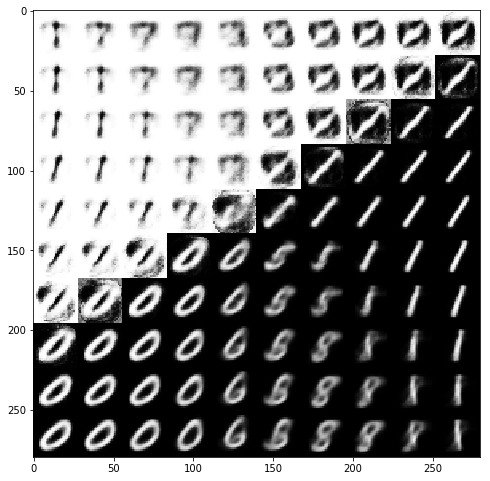

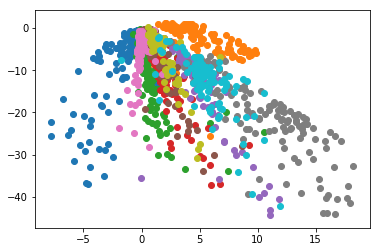

In [ ]:
loss_op = vae_loss(decoder, tf.reshape(X, [-1, 28*28]), reconstruction_loss=True, kl_loss=False)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(loss_op)
sess.run(tf.global_variables_initializer())

train(50)
plot_generated()
plot_means()

But if you just use the kl loss, the datapoints will be mapped to the to the standard normal distribution, but the decoder does not re-construct meaningful data points:

In [ ]:
loss_op = vae_loss(decoder, tf.reshape(X, [-1, 28*28]), reconstruction_loss=False, kl_loss=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.00001)
train_op = optimizer.minimize(loss_op)
sess.run(tf.global_variables_initializer())

train(50)
plot_generated()
plot_means()

Epoch 0: loss 457.6196
Epoch 1: loss 96.7508
Epoch 2: loss 40.7418
Epoch 3: loss 21.6816
Epoch 4: loss 14.4362
Epoch 5: loss 11.0783
Epoch 6: loss 9.2368
Epoch 7: loss 8.0681
Epoch 8: loss 7.2420
Epoch 9: loss 6.6134
Epoch 10: loss 6.1102
Epoch 11: loss 5.6929
Epoch 12: loss 5.3378
Epoch 13: loss 5.0297
Epoch 14: loss 4.7584
Epoch 15: loss 4.5168
Epoch 16: loss 4.2996
Epoch 17: loss 4.1028
Epoch 18: loss 3.9235
Epoch 19: loss 3.7591
Epoch 20: loss 3.6077
Epoch 21: loss 3.4676
Epoch 22: loss 3.3377
Epoch 23: loss 3.2166
Epoch 24: loss 3.1035
Epoch 25: loss 2.9975
Epoch 26: loss 2.8980
Epoch 27: loss 2.8043
Epoch 28: loss 2.7159
Epoch 29: loss 2.6324
Epoch 30: loss 2.5532
Epoch 31: loss 2.4781
Epoch 32: loss 2.4068
Epoch 33: loss 2.3389
Epoch 34: loss 2.2741
Epoch 35: loss 2.2124
Epoch 36: loss 2.1533
Epoch 37: loss 2.0969
Epoch 38: loss 2.0428
Epoch 39: loss 1.9909
Epoch 40: loss 1.9411
Epoch 41: loss 1.8933
Epoch 42: loss 1.8473
Epoch 43: loss 1.8031
Epoch 44: loss 1.7604
Epoch 45: los

In [ ]:
sess.close()